In [1]:
import cv2

In [2]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
# Load the Haarcascades face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [4]:
# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
def detect_faces_and_parts(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    upper_faces = []
    lower_faces = []

    for (x, y, w, h) in faces:
        upper_face = image[y:y + h // 2, x:x + w]
        lower_face = image[y + h // 2:y + h, x:x + w]
        upper_faces.append(upper_face)
        lower_faces.append(lower_face)

    return upper_faces, lower_faces

In [7]:
# Load an example image (replace 'path_to_your_image.jpg' with the actual path)
image_path = 'happy2.jpeg'
image = cv2.imread(image_path)

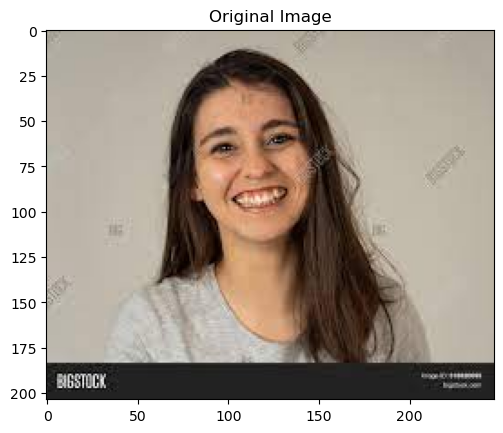

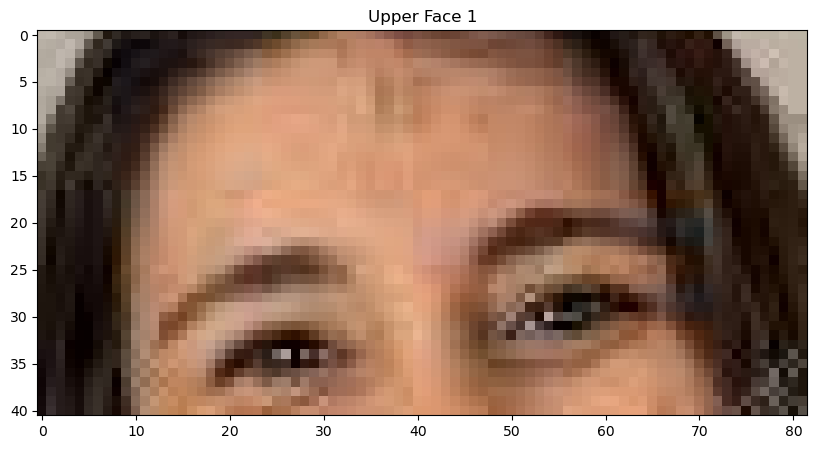

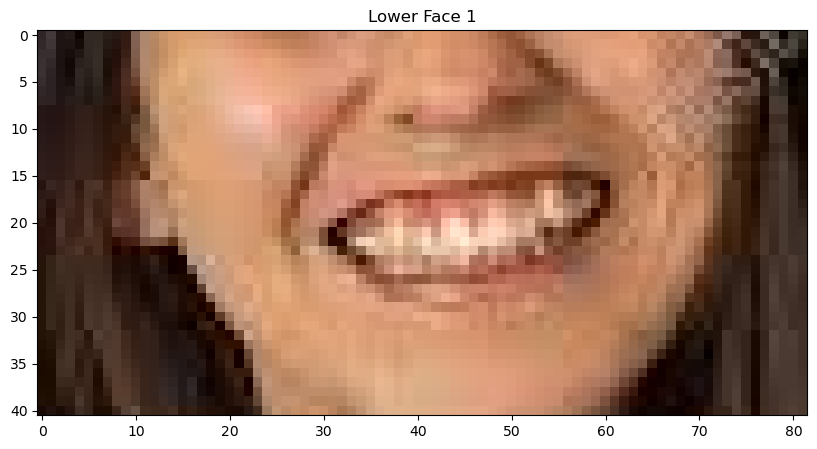

In [8]:
# Check if the image is loaded successfully
if image is None:
    print(f"Error: Unable to load the image from {image_path}")
else:
    # Use the detect_faces_and_parts function
    upper_faces, lower_faces = detect_faces_and_parts(image)

    # Display the original image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.show()

    # Display upper faces
    plt.figure(figsize=(15, 5))
    for i, upper_face in enumerate(upper_faces):
        plt.subplot(1, len(upper_faces), i + 1)
        plt.imshow(cv2.cvtColor(upper_face, cv2.COLOR_BGR2RGB))
        plt.title(f'Upper Face {i + 1}')
    plt.show()

    # Display lower faces
    plt.figure(figsize=(15, 5))
    for i, lower_face in enumerate(lower_faces):
        plt.subplot(1, len(lower_faces), i + 1)
        plt.imshow(cv2.cvtColor(lower_face, cv2.COLOR_BGR2RGB))
        plt.title(f'Lower Face {i + 1}')
    plt.show()

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [10]:
data = pd.read_csv('fer_2013csv.csv')

In [11]:
# Extract pixel values and emotion labels
pixels = data['pixels'].tolist()
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(48, 48)  # assuming images are 48x48
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)  # Add channel dimension

emotions = pd.get_dummies(data['emotion']).to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train /= 255.0
X_test /= 255.0

In [14]:
# Build the CNN model

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))


# Adding dropout and L2 regularization
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))


model.add(Dense(7, activation='softmax')) 


In [15]:
from tensorflow.keras.optimizers import Adam

# Compile the model

custom_optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/40
449/449 [==============================] - 288s 636ms/step - loss: 3.4212 - accuracy: 0.2393 - val_loss: 2.6891 - val_accuracy: 0.2558
Epoch 2/40
449/449 [==============================] - 271s 604ms/step - loss: 2.3306 - accuracy: 0.3055 - val_loss: 2.0258 - val_accuracy: 0.3484
Epoch 3/40
449/449 [==============================] - 265s 591ms/step - loss: 1.9014 - accuracy: 0.3763 - val_loss: 1.7735 - val_accuracy: 0.3975
Epoch 4/40
449/449 [==============================] - 281s 627ms/step - loss: 1.7308 - accuracy: 0.4028 - val_loss: 1.6693 - val_accuracy: 0.4135
Epoch 5/40
449/449 [==============================] - 279s 621ms/step - loss: 1.6323 - accuracy: 0.4223 - val_loss: 1.5675 - val_accuracy: 0.4344
Epoch 6/40
449/449 [==============================] - 256s 570ms/step - loss: 1.5588 - accuracy: 0.4397 - val_loss: 1.4954 - val_accuracy: 0.4588
Epoch 7/40
449/449 [==============================] - 282s 627ms/step - loss: 1.4991 - accuracy: 0.4577 - val_loss: 1.4451 -

In [17]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

225/225 [==============================] - 16s 69ms/step - loss: 1.1754 - accuracy: 0.5862
Test Accuracy: 58.62%


# Evaluate the Model and Generate Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [19]:
# Use the trained model to make predictions
y_pred = model.predict(X_test)

225/225 [==============================] - 15s 66ms/step


In [20]:
# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [21]:

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 486    0   75   67  187   14  156]
 [  55   10   15    5   15    1    1]
 [ 122    0  347   81  288   79  126]
 [  76    0   39 1423   88   33  106]
 [ 121    0  115  100  621    9  244]
 [  21    0  104   56   31  533   50]
 [  73    0   54  125  230    8  788]]


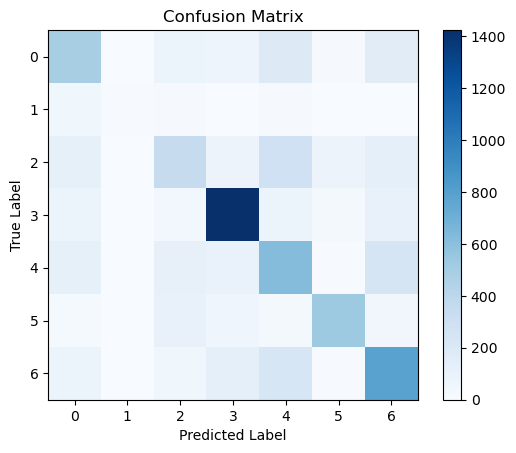

In [22]:
# Display or save confusion matrix (optional)
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [24]:
classification_rep=classification_report (y_true, y_pred)

In [25]:
# Print metrics
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       985
           1       1.00      0.10      0.18       102
           2       0.46      0.33      0.39      1043
           3       0.77      0.81      0.79      1765
           4       0.43      0.51      0.47      1210
           5       0.79      0.67      0.72       795
           6       0.54      0.62      0.57      1278

    accuracy                           0.59      7178
   macro avg       0.64      0.50      0.52      7178
weighted avg       0.59      0.59      0.58      7178



In [26]:
# Save the trained model
model.save('Upper_recognition_model.h5')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
